In [1]:
import sys

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline
from water_batch import WaterBatch
sys.path.append('..')
import dataset
import utils
from dataset import B,V,F, FilesIndex, Dataset, Pipeline
from dataset.dataset.models.tf import ResNet101, DenseNet121, VGG19

In [2]:
def concatenate_water(batch, model, return_targets=True):
    _ = model
    x = np.concatenate(np.concatenate(batch.sepcrop))
    x = x.reshape(batch.sepcrop.shape[0]*8, 64, 32, 3)
    y = np.concatenate(batch.labels).reshape(-1)
    
#     split_indices = np.cumsum([item.sepcrop.shape[0] for item in batch])[:-1]
    res_dict = {"feed_dict": {"images": x, "labels": y}}
#     if return_targets:
#         y = np.concatenate([np.tile(item.target, (item.signal.shape[0], 1)) for item in batch])
#         res_dict["feed_dict"]["targets"] = y
    return res_dict

In [3]:
src = 'data/images/'
di = os.listdir(src)

fileindex = FilesIndex(path='./data/images/*.jpg', no_ext=True)

dset = Dataset(fileindex, batch_class=WaterBatch)
dset.cv_split()

In [4]:
b = (Pipeline()
        .load(src=src, fmt='jpg', components='images')
        .load(src='./data/labels/meters.csv', \
              fmt='csv',\
              components='labels',\
              usecols=['file_name', 'counter_value'])
        .load(src='./data/labels/answers.csv', \
              fmt='csv', \
              components='coordinates',\
              usecols=['markup'])
        .crop_to_bbox()
        .crop_to_numbers()
        .crop_labels())

In [5]:
inputs_config = {
    'images': {'shape':(64, 32, 3)},
    'labels':{'classes':(10), 'transform':'ohe', 'name':'targets'}
}

config = {
    'inputs':inputs_config,
    'optimizer': 'Adam',
    'loss': 'ce',
    'input_block/inputs': 'images',
    'head/units': 10,
    'output': dict(ops=['labels', 'proba', 'accuracy'])}

# ЗАДАМПИ МОДЕЛ

In [6]:
models = [DenseNet121, VGG19, ResNet101]
models_names = ['DenseNet121', 'VGG19', 'ResNet101']
models_dict = dict(zip(models_names, models))

In [7]:
def get_ppl(model, name):
    train_ppl = ((b<<dset.train)
                 .init_variable('model', model)
                 .init_variable('loss', init_on_each_run=list)
                 .init_model('dynamic',
                            V('model'),
                            name,
                            config=config)
                 .train_model(name,
                             fetches='loss',
                             make_data=concatenate_water,
                             save_to=V('loss'), mode='a'))

    test_ppl = ((b<<dset.test)
                 .init_variable('proba', init_on_each_run=list)
                 .init_variable('target', init_on_each_run=list)
                 .init_variable('accuracy', init_on_each_run=list)
                 .import_model(name, train_ppl)
                 .predict_model(name,
                                fetches=['output_proba',
                                         'targets', 'output_accuracy'],
                                make_data=concatenate_water,
                                save_to=[V('proba'), V('target'), V('accuracy')], mode='a'))
    return train_ppl, test_ppl

In [8]:
global_acc = []

for name, model in models_dict.items():
    print(name)
    train_ppl, test_ppl = get_ppl(model, name)
    acc=[]
    for i in tqn(range(3000)):
        train_ppl.next_batch(25, n_epochs=None, suffle=True)
        test_ppl.next_batch(25, n_epochs=None, suffle=True)

    utils.draw(test_ppl.get_variable('accuracy'), name, type_data='accuracy')
    plt.show()
    global_acc.append(test_ppl.get_variable('accuracy'))
    train_ppl.save_model(name, path=name)

DenseNet121


Widget Javascript not detected.  It may not be installed or enabled properly.


/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


[AttributeError("'numpy.ndarray' object has no attribute 'replace'",)]


  File "../dataset/dataset/decorators.py", line 478, in _call_post_fn
    result = future.result()
  File "/usr/lib/python3.5/concurrent/futures/_base.py", line 398, in result
    return self.__get_result()
  File "/usr/lib/python3.5/concurrent/futures/_base.py", line 357, in __get_result
    raise self._exception
  File "/usr/lib/python3.5/concurrent/futures/thread.py", line 55, in run
    result = self.fn(*self.args, **self.kwargs)
  File "/home/anton/allwork/_work/az_training/anton_broilovskiy/water_meter/water_batch.py", line 88, in crop_labels
    more_label = np.array([int(i) for i in label.replace('.', '')] + [None])[:-1]


ValueError: all the input arrays must have same number of dimensions

In [12]:
train_ppl.save_model(name, path=name)

../utils.py:45: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)


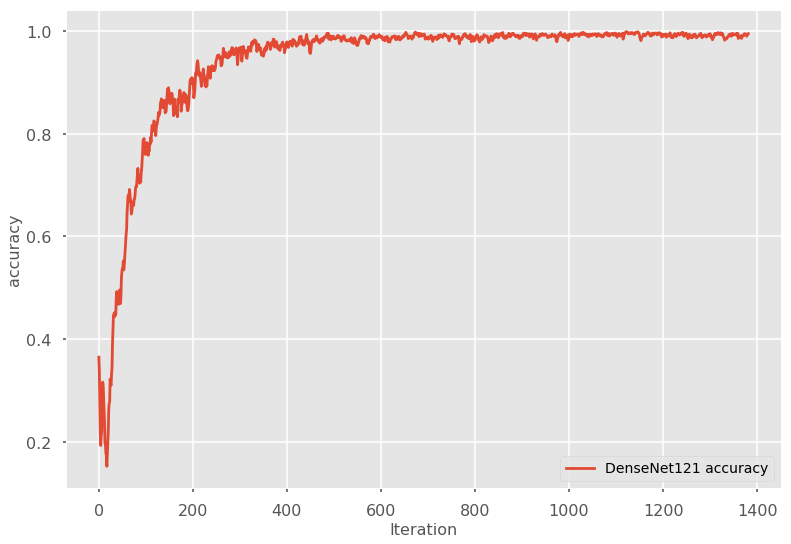

In [11]:
utils.draw(test_ppl.get_variable('accuracy'), name, type_data='accuracy')

In [17]:
predict_ppl = ((b<<dset.test)
               .init_variable('prediction', init_on_each_run=list)
               .init_variable('proba', init_on_each_run=list)
               .init_variable('accuracy', init_on_each_run=list)
               .import_model('DenseNet121', train_ppl)
               .predict_model('DenseNet121',
                              fetches=['output_labels',
                                       'output_proba', 'output_accuracy'],
                              make_data=concatenate_water,
                              save_to=[V('prediction'), V('proba'), V('accuracy')], mode='a'))

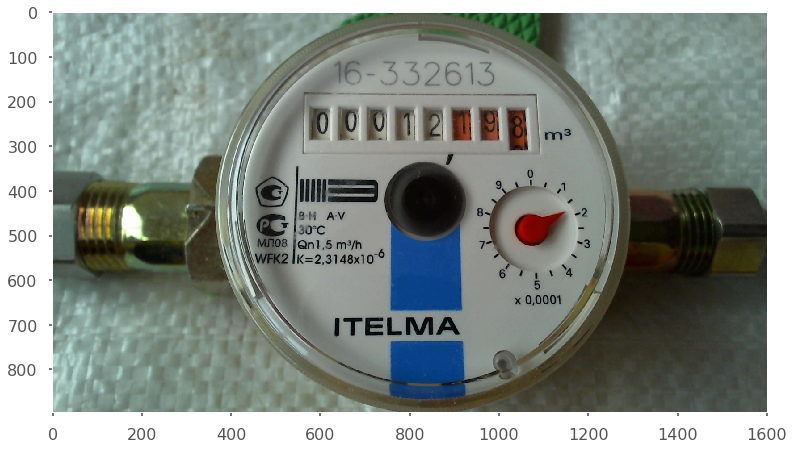

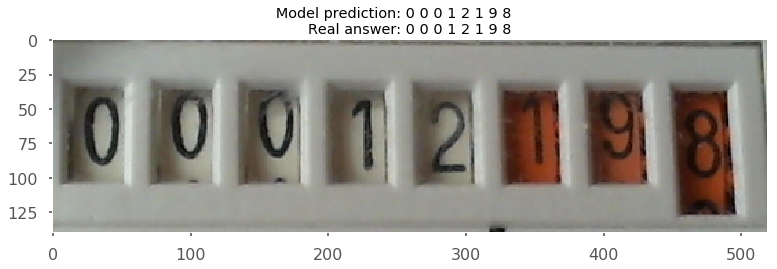

In [52]:
batch_test = predict_ppl.next_batch(1, n_epochs=None, shuffle=True)

predict = predict_ppl.get_variable('prediction')[-1]
labels = batch_test.labels[-1]
plt.imshow(batch_test.images[-1])
plt.grid()
plt.show()
plt.title('   Model prediction: {} {} {} {} {} {} {} {}\
          \nReal answer: {} {} {} {} {} {} {} {}'.format(*predict, *labels))
plt.imshow(batch_test.cropped[-1])
plt.grid()